# COMP 551 Mini Project 2
* Yann Bourdé - 260838140
* Marie Ezra Marin - 261053813
* Ethan Kreuzer - 261050944

# Task 1: Acquire, preprocess, and analyze the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from skimage import io

from google.colab import drive
drive.mount('/content/drive')

# Please update the path to the csv file according to your own location.
path = "/content/drive/MyDrive/McGill/COMP 551/Mini2/batches/"

Mounted at /content/drive


In [2]:
# Function to unpickle image files.
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict
# End of function.

In [3]:
# Function to convert the batch files to 1 large numpy with 10000, 32x32 colour images.
def getimages(batch):
  data = batch[b'data']
  img = np.zeros((10000, 1, 32, 32, 3), dtype=int)
  offset = 32
  for j in range(10000):
    for i in range(0, 32):
      y = i*offset
      img[j, 0, i, :, 0] = data[j, y:y+32]
      img[j, 0, i, :, 1] = data[j, y+1024:y+1024+32]
      img[j, 0, i, :, 2] = data[j, y+2048:y+2048+32]
  return img
# End of function.

In [4]:
# Get all input data into one numpy (and matching lables into another one).
big_data = np.empty((10000, 1, 32, 32, 3), dtype=int)
big_labels = np.empty((10000), dtype=int)
for i in range(1, 6):
  batch = unpickle(path + 'data_batch_'+ str(i))
  np_labels = batch[b'labels']
  big_labels = np.concatenate((big_labels, np_labels))
  np_batch = getimages(batch)
  big_data = np.concatenate((big_data, np_batch))
big_data = np.delete(big_data, np.s_[0:10000], axis=0)
big_labels = np.delete(big_labels, np.s_[0:10000], axis=0)

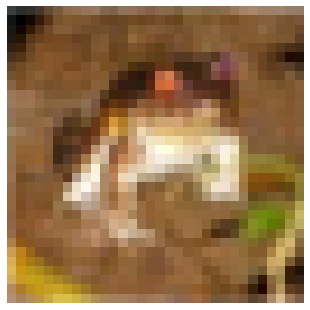

In [5]:
# Show test image.
img = big_data[0, 0]
plt.figure(figsize=(12,12))
plt.subplot(2, 2, 1)
plt.imshow(img)
plt.axis('off');

In [6]:
# Get big_X. big_X is just used to display the images.
big_X = np.empty((10000, 3072), dtype=int)
for i in range(1, 6):
  batch = unpickle(path + 'data_batch_'+ str(i))
  np_batch = batch[b'data']
  big_X = np.concatenate((big_X, np_batch))
big_X = np.delete(big_X, np.s_[0:10000], axis=0)

In [7]:
# Get all test data into one numpy (and matching labels into another one).
test = unpickle(path + 'test_batch')
np_test = test[b'data']
test_labels = test[b'labels'] 

In [8]:
# Function that makes a N x number matrix for the labels. If the label is 7, then the column at index 7 will be be 1 and the other 0 (one hot encoded).
def label(array, number):
  new_labels = np.zeros((len(array), number))
  for i in range(len(array)):
    index = array[i]
    new_labels[i,index] = 1
  return new_labels
# End of function.

In [9]:
# Function for normalizing RGB values. It divides by 255. 
def normalize(train, test):
  u = np.mean(train)
  std = np.std(train)

  norm_train = train
  max = np.max(norm_train)
  min = np.min(norm_train)

  norm_train = (norm_train - np.min(norm_train))/(np.max(norm_train)-np.min(norm_train)) # Normalize
  norm_train = norm_train * (1 - (-1)) + (-1) # Rescale [-1, 1]

  norm_test = test
  norm_test = (norm_test - np.min(norm_test))/(np.max(norm_test)-np.min(norm_test))
  norm_test = norm_test * (1 - (-1)) + (-1)

  return norm_train, norm_test
# End of function.

In [10]:
# Function that outputs the class number based on which index is 1. Opposite of 'label' function above.
def getclasses(array):
  N,D = array.shape
  results = np.zeros((N))
  for j in range(N):
      i = np.argmax(array[j])
      results[j] = i
  return results
# End of function.

In [59]:
# Format labels for training.
big_labels_new = label(big_labels, 10)

# Normalize dataset.
big_X_norm, test_norm = normalize(big_X, np_test)

# Task 2: Implement a Multilayer Perceptron.

In [11]:
# Define activation functions.
from numpy.ma.core import tanh
# Define activation functions.
logistic = lambda z: 1./ (1 + np.exp(-z))
deriv_log = lambda z: z*(1-z)
activation_ReLU = (lambda x: x*(x > 0))
deriv_ReLU = (lambda x: 1 * (x>0))
activation_tanh = (lambda x: tanh(x))
deriv_tanh = (lambda x: 1-activation_tanh(x)**2)

In [12]:
# Leaky ReLU. 
def activation_leaky_ReLU(x):
  x = np.where(x > 0, x, 0.01*x)
  return x

In [13]:
# Derivative of leaky ReLU.
def deriv_leaky_ReLU(x):
  x = np.where(x > 0, 1, 0.01)
  return x

In [14]:
# Softmax implementation.
def softmax(x):
  try:
    row, col = x.shape
    softmax = np.zeros((row, col))
    for i in range(row):
      softmax[i] = np.exp(x[i] - np.max(x[i])) / np.sum(np.exp(x[i] - np.max(x[i])))
    return softmax
  except:
    return np.exp(x - np.max(x)) / np.sum(np.exp(x - np.max(x)))

In [15]:
# Computes the derivative of the softmax function. Output is N x N.
def d_soft(softmax, N, err):
  d_softmax_big = np.zeros((N,10))
  for i in range(N):
    softmax_row = np.reshape(softmax[i, :], (1, -1)) # Grab row and reshape as 1x10.
    d_softmax = (softmax_row * np.identity(softmax_row.size) - softmax_row.transpose() @ softmax_row)
    delta = err[i, :] @ d_softmax
    d_softmax_big[i] = delta
    # d_softmax_big[i] = d_softmax
  return d_softmax_big

In [124]:
# Function to evaluate the prediction accuracy.
def evaluate_acc(pred, truth):
  cnt = 0
  for i in range(len(pred)):
    if pred[i] == truth[i]:
      cnt = cnt + 1
  acc = cnt/len(pred)
  return acc

Class MLP desciption (PLEASE READ)

This class is composed of 7 different functions and below is a description for all of them:

- *cross_entropy*: this function computes categorical cross entropy loss.
- *cross_E_grad*: this function computes the derivative of categorical cross entropy loss.
- *getbatches*: this function creates batches based on the indicated batch size.
- *GD*: this function computes the gradient descent part of the class. This is where iterations take place and where the weights get updated. It is also used to record useful metrics and compute accuracy per epoch if required.
  - Each epoch iterates through all randomly created batches and update the weights.
- ***gradient***: this function is were the forward and backpropagation part happen. 
  - There are 3 sections, one for each layer (0, 1 and 2). 
  - Each section has a bias=True part and bias=False part.
  - In each bias part, we first compute a forward pass with the current weights.
  - Then we compute the error and proceed through the backpropagation algorithm to obtain the changes for the weights.
  - Each section has conditional statements for various otpimization paramters such as L1/L2 regularization and dropout.
- *fit*: this function initializes the weights and biases based on the number of layers requested and calls the *GD* function.
- *predict*: this function implements a forward pass using the current weights of the model to calculate the predictions.

In [125]:
class MLP:
  def __init__(self, add_bias=True, layer_num=1, M=256, batch_size=32, learning_rate=.01, max_iters=1e4, epsilon=1e-8, activation = activation_ReLU, is_stochastic=False, l1=0, l2=0, momentum=0, drop=0, acc=False, predic_test=test_norm, truth_test=test_labels, predic_train=big_X_norm, truth_train=big_labels):
    self.add_bias = add_bias
    self.layer_num = layer_num
    self.M = M
    self.batch_size = batch_size
    self.learning_rate = learning_rate
    self.max_iters = max_iters
    self.epsilon = epsilon
    self.params = []
    self.bias = []
    self.activation = activation
    self.deriv = (
        deriv_ReLU if activation_ReLU == activation_ReLU 
        else deriv_log if activation==logistic
        else deriv_leaky_ReLU if activation == activation_leaky_ReLU
        else deriv_tanh if activation==activation_tanh 
        else None
    )
    self.is_stochastic = is_stochastic
    self.loss = 0
    self.dloss = 0
    self.l1 = l1
    self.l2 = l2
    self.momentum = momentum;
    self.update = []
    self.bdate = []
    self.drop = drop
    self.loss_list = []
    self.acc = acc
    self.predic_test = predic_test
    self.predic_train = predic_train
    self.truth_test = truth_test
    self.truth_train = truth_train
    self.accuracy_list_test = []
    self.accuracy_list_train = []
    pass

  def cross_entropy(self, yh, y):
    self.loss = -np.sum(y * np.log(yh + 10**-100))/(len(yh))
    # print(self.loss)
    return self

  def cross_E_grad(self, yh, y):
    loss = -y/(yh + 10**-100)
    return loss

  def getbatches(self, x, y):
    N,D = x.shape
    x_list = []
    y_list = []
    number = int(N/self.batch_size)
    if self.is_stochastic:
      nx,dx = x.shape
      xy = np.column_stack((x,y))
      np.random.shuffle(xy)
      x = xy[:,:D]
      y = xy[:,D:]
    for i in range(number):
      batch_x = x[i*self.batch_size:i*self.batch_size+self.batch_size, :]
      x_list.append(batch_x)
      batch_y = y[i*self.batch_size:i*self.batch_size+self.batch_size, :]
      y_list.append(batch_y)
    return x_list, y_list 

  def GD(self, x, y):
    x_list, y_list = (None, None)
    if not self.is_stochastic:
      x_list, y_list = self.getbatches(x, y)
    norms = np.array([np.inf])
    initial_rate = self.learning_rate
    t = 0
    while t < self.max_iters:
      self.learning_rate = initial_rate/(1+(t/10))
      if self.is_stochastic:
        x_list, y_list = self.getbatches(x, y)
      for i in range(len(x_list)):
        x_b = x_list[i]
        y_b = y_list[i]
        if self.add_bias:
          grad, bias = self.gradient(x_b, y_b)
        else:
          grad, bias = self.gradient(x_b, y_b)
        for p in range(len(self.params)):
          if self.momentum != 0:
            update = -1.0*self.learning_rate * grad[p] + self.momentum * self.update[p]
            self.params[p] -= self.learning_rate * grad[p] + self.momentum * update
          else:
            self.params[p] -= self.learning_rate * grad[p]

          if self.add_bias:
            if self.momentum !=0:
              update = -1.0*self.learning_rate * bias[p] + self.momentum * self.bdate[p]
              self.bias[p] -= self.learning_rate * bias[p] + self.momentum * update
            else:
              self.bias[p] -= self.learning_rate * bias[p]

        if self.loss <= self.epsilon:
          return self
      t += 1
      self.loss_list.append(self.loss)

      if self.acc:
        predictions_test = self.predict(self.predic_test)
        predictions_train = self.predict(self.predic_train)
        predictions_test = getclasses(predictions_test)
        predictions_train = getclasses(predictions_train)
        accuracy_test = evaluate_acc(predictions_test, self.truth_test)*100
        accuracy_train = evaluate_acc(predictions_train, self.truth_train)*100
        self.accuracy_list_test.append(accuracy_test)
        self.accuracy_list_train.append(accuracy_train)
      # print(self.learning_rate)
    return self
        
  def gradient(self, x, y):
    N,D = x.shape
    d_bias = []
    # Three cases.

    #### 0 LAYER ####
    if self.layer_num == 0:
      w = self.params[0]
      if self.add_bias:
        ## Forward pass.
        b = self.bias[0]
        yh = softmax(np.dot(x, w) + b)

        ## Backpropagation
        # err_y = yh - y
        err_y = self.cross_E_grad(yh, y)
        delta_y = d_soft(yh, N, err_y)
        change_w = np.dot(x.T, delta_y)/N
        change_b = np.sum(delta_y, axis=0, keepdims=True)

        # Apply regularization.
        if self.l1 != 0:
          change_w = change_w + self.l1 * (w /(abs(w) + 10**-100)) 
        if self.l2 != 0:
          change_w = change_w + self.l2 * 2 * w 

        d_params = [change_w]
        d_bias = [change_b]
      else:
        ## Forward pass.
        yh = softmax(np.dot(x, w))

        ## Backpropagation
        # err_y = yh - y
        err_y = self.cross_E_grad(yh, y)
        delta_y = d_soft(yh, N, err_y)
        change_w = np.dot(x.T, delta_y)/N

        if self.l1 != 0:
          change_w = change_w + self.l1 * (w /(abs(w) + 10**-100)) 
        if self.l2 != 0:
          change_w = change_w + self.l2 * 2 * w 

        d_params = [change_w]

    #### 1 LAYER ####
    elif self.layer_num == 1:
      v, w = self.params
      if self.add_bias:
        bv, bw = self.bias
        ## Forward pass.
        z = self.activation(np.dot(x, v) + bv)
        if self.drop != 0:
          U1 = (np.random.rand(*z.shape) < self.drop) / self.drop
          z *= U1 # drop!
        yh = softmax(np.dot(z, w) + bw)

        ## Backpropagation
        # err_y = yh - y
        err_y = self.cross_E_grad(yh, y)
        delta_y = d_soft(yh, N, err_y)
        change_w = np.dot(z.T, delta_y)/N
        change_bw = np.sum(delta_y, axis=0, keepdims=True)

        # Apply regularization.
        if self.l1 != 0:
          change_w = change_w + self.l1 * (w /(abs(w) + 10**-100)) 
        if self.l2 != 0:
          change_w = change_w + self.l2 * 2 * w 
      
        err_z = np.dot(delta_y, w.T)
        delta_z = err_z * self.deriv(z)
        change_v = np.dot(x.T, delta_z)/N
        change_bv = np.sum(delta_z, axis=0, keepdims=True)

        # Apply regularization.
        if self.l2 != 0:
          change_v = change_v + self.l2 * 2 * v 

        d_params = [change_v, change_w]
        d_bias = [change_bv, change_bw]

      else:
        ## Forward pass.
        z = self.activation(np.dot(x, v))
        if self.drop != 0:
          U1 = (np.random.rand(*z.shape) < self.drop) / self.drop
          z *= U1 # drop!
        yh = softmax(np.dot(z, w))

        ## Backpropagation
        # err_y = yh - y
        err_y = self.cross_E_grad(yh, y)
        delta_y = d_soft(yh, N, err_y)
        change_w = np.dot(z.T, delta_y)/N

        # Apply regularization.
        if self.l1 != 0:
          change_w = change_w + self.l1 * (w /(abs(w) + 10**-100)) 
        if self.l2 != 0:
          change_w = change_w + self.l2 * 2 * w 
      
        err_z = np.dot(delta_y, w.T)
        delta_z = err_z * self.deriv(z)
        change_v = np.dot(x.T, delta_z)/N

        # Apply regularization.
        if self.l2 != 0:
          change_v = change_v + self.l2 * 2 * v 
        
        d_params = [change_v, change_w]

    #### 2 LAYER ####
    elif self.layer_num == 2:
      v0, v, w = self.params
      if self.add_bias:
        bv1, bv2, bw = self.bias
        ## Forward pass.
        z0 = self.activation(np.dot(x, v0) + bv1)
        if self.drop != 0:
          U1 = (np.random.rand(*z0.shape) < self.drop) / self.drop
          z0 *= U1 # drop!  
        z = self.activation(np.dot(z0, v) + bv2)
        if self.drop != 0:
          U2 = (np.random.rand(*z.shape) < self.drop) / self.drop
          z *= U2 # drop
        yh = softmax(np.dot(z, w) + bw)

        ## Backpropagation
        # err_y = yh - y
        err_y = self.cross_E_grad(yh, y)
        delta_y = d_soft(yh, N, err_y)
        change_w = np.dot(z.T, delta_y)/N
        change_bw = np.sum(delta_y, axis=0, keepdims=True)

        # Apply regularization.
        if self.l1 != 0:
          change_w = change_w + self.l1 * (w /(abs(w) + 10**-100)) 
        if self.l2 != 0:
          change_w = change_w + self.l2 * 2 * w 
      
        err_z = np.dot(delta_y, w.T)
        delta_z = err_z * self.deriv(z)
        change_v = np.dot(z0.T, delta_z)/N
        change_bv2 = np.sum(delta_z, axis=0, keepdims=True)

        # Apply regularization.
        if self.l1 != 0:
          change_v = change_v + self.l1 * (v /(abs(v) + 10**-100)) 
        if self.l2 != 0:
          change_v = change_v + self.l2 * 2 * v 

        err_z0 = np.dot(delta_z, v.T)
        delta_z0 = err_z0 * self.deriv(z0)
        change_v0 = np.dot(x.T, delta_z0)/N
        change_bv1 = np.sum(delta_z0, axis=0, keepdims=True)

        if self.l2 != 0:
          change_v0 = change_v0 + self.l2 * 2 * v0 
        
        d_params = [change_v0, change_v, change_w]
        d_bias = [change_bv1, change_bv2, change_bw]
      else:
        ## Forward pass.
        z0 = self.activation(np.dot(x, v0))
        if self.drop != 0:
          U1 = (np.random.rand(*z0.shape) < self.drop) / self.pdrop
          z0 *= U1 # drop!  
        z = self.activation(np.dot(z0, v))
        if self.drop != 0:
          U2 = (np.random.rand(*z.shape) < self.drop) / self.drop
          z *= U2 # drop
        yh = softmax(np.dot(z, w))

        ## Backpropagation
        # err_y = yh - y
        err_y = self.cross_E_grad(yh, y)
        delta_y = d_soft(yh, N, err_y)
        change_w = np.dot(z.T, delta_y)/N

        # Apply regularization.
        if self.l1 != 0:
          change_w = change_w + self.l1 * (w /(abs(w) + 10**-100)) 
        if self.l2 != 0:
          change_w = change_w + self.l2 * 2 * w 
      
        err_z = np.dot(delta_y, w.T)
        delta_z = err_z * self.deriv(z)
        change_v = np.dot(z0.T, delta_z)/N

        # Apply regularization.
        if self.l1 != 0:
          change_v = change_v + self.l1 * (v /(abs(v) + 10**-100)) 
        if self.l2 != 0:
          change_v = change_v + self.l2 * 2 * v 

        err_z0 = np.dot(delta_z, v.T)
        delta_z0 = err_z0 * self.deriv(z0)
        change_v0 = np.dot(x.T, delta_z0)/N

        if self.l2 != 0:
          change_v0 = change_v0 + self.l2 * 2 * v0 
        
        d_params = [change_v0, change_v, change_w]

    self.cross_entropy(yh, y)
    return d_params, d_bias


  def fit(self, x, y):
    N,D = x.shape
    # Three possible cases, no hidden, 1 hidden, 2 hidden.
    if self.layer_num == 0:
      w = np.random.randn(D, 10) * np.sqrt(2/D)
      self.params = [w]
      if self.add_bias:
        b = np.zeros((1,10))
        self.bias = [b]
        update_b = np.zeros(b.shape)
        self.bdate = [update_b]
      update_w = np.zeros(w.shape)
      self.update = [update_w]

    elif self.layer_num == 1:
      w = np.random.randn(self.M, 10) * np.sqrt(2/self.M)
      v = np.random.randn(D,self.M) * np.sqrt(2/D)
      self.params = [v,w]
      if self.add_bias:
        bw = np.zeros((1,10))
        bv = np.zeros((1,self.M))
        self.bias = [bv, bw]
        update_bw = np.zeros(bw.shape)
        update_bv = np.zeros(bv.shape)
        self.bdate = [update_bv, update_bw]
      update_w = np.zeros(w.shape)
      update_v = np.zeros(v.shape)
      self.update = [update_v, update_w]

    elif self.layer_num == 2:
      w = np.random.randn(self.M, 10) * np.sqrt(2/self.M)
      v2 = np.random.randn(self.M,self.M) * np.sqrt(2/self.M)
      v1 = np.random.randn(D,self.M) * np.sqrt(2/D)
      self.params = [v1,v2,w]
      if self.add_bias:
        bw = np.zeros((1,10))
        bv2 = np.zeros((1,self.M))
        bv1 = np.zeros((1,self.M))
        self.bias = [bv1, bv2, bw]
        update_bw = np.zeros(bw.shape)
        update_bv2 = np.zeros(bv2.shape)
        update_bv1 = np.zeros(bv1.shape)
        self.bdate = [update_bv1, update_bv2, update_bw]
      update_w = np.zeros(w.shape)
      update_v2 = np.zeros(v2.shape)
      update_v1 = np.zeros(v1.shape)
      self.update = [update_v1, update_v2, update_w]
    self.GD(x, y)
    return self

  def predict(self, x):
    N,D = x.shape
    output = np.zeros((N,10))
    if self.layer_num == 0:
      w = self.params[0]
      if self.add_bias:
        b = self.bias[0]
        yh = softmax(np.dot(x, w) + b)
      else:
        yh = softmax(np.dot(x, w))
    elif self.layer_num == 1:
      v, w = self.params
      if self.add_bias:
        bv, bw = self.bias
        z = self.activation(np.dot(x, v) + bv)
        yh = softmax(np.dot(z, w) + bw)
      else:
        z = self.activation(np.dot(x, v))
        yh = softmax(np.dot(z, w))
    elif self.layer_num == 2:
      v1, v2, w = self.params
      if self.add_bias:
        bv1, bv2, bw = self.bias
        z1 = self.activation(np.dot(x, v1) + bv1)
        z2 = self.activation(np.dot(z1, v2) + bv2)
        yh = softmax(np.dot(z2, w) + bw)
      else:
        z1 = self.activation(np.dot(x, v1))
        z2 = self.activation(np.dot(z1, v2))
        yh = softmax(np.dot(z2, w)) 
    return yh

# Task 3: Run the experiments.

In [26]:
# Format labels for training.
big_labels_new = label(big_labels, 10)

# Normalize dataset.
big_X_norm, test_norm = normalize(big_X, np_test)

In [79]:
batch_size_global = 16
iterations_global = 10

## Experiment 1

In [29]:
model0 = MLP(layer_num = 0, batch_size = batch_size_global, activation = activation_ReLU, is_stochastic=True, add_bias=True, max_iters=iterations_global, learning_rate=.01, M=256, l1=0, l2=0, momentum=0, drop=0)
model1 = MLP(layer_num = 1, batch_size = batch_size_global, activation = activation_ReLU, is_stochastic=True, add_bias=True, max_iters=iterations_global, learning_rate=.01, M=256, l1=0, l2=0, momentum=0, drop=0)
model2 = MLP(layer_num = 2, batch_size = batch_size_global, activation = activation_ReLU, is_stochastic=True, add_bias=True, max_iters=iterations_global, learning_rate=.01, M=256, l1=0, l2=0, momentum=0, drop=0)

In [30]:
model0.fit(big_X_norm, big_labels_new)

In [31]:
model1.fit(big_X_norm, big_labels_new)

In [32]:
model2.fit(big_X_norm, big_labels_new)

In [33]:
pred0 = model0.predict(test_norm)
pred1 = model1.predict(test_norm)
pred2 = model2.predict(test_norm)

In [127]:
pred0c = getclasses(pred0)
pred1c = getclasses(pred1)
pred2c = getclasses(pred2)

acc0 = evaluate_acc(pred0c, test_labels)
acc1 = evaluate_acc(pred1c, test_labels)
acc2 = evaluate_acc(pred2c, test_labels)

print("Accuracy of 0 layers with M=256, ReLU: ", acc0*100, "%")
print("Accuracy of 1 layers with M=256, ReLU: ", acc1*100, "%")
print("Accuracy of 2 layers with M=256, ReLU: ", acc2*100, "%")

Accuracy of 0 layers with M=256, ReLU:  39.300000000000004 %
Accuracy of 1 layers with M=256, ReLU:  53.16 %
Accuracy of 2 layers with M=256, ReLU:  53.14 %


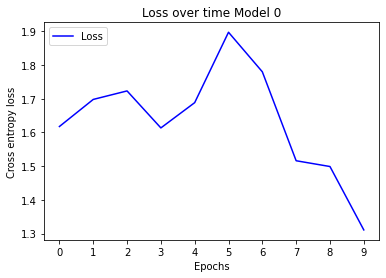

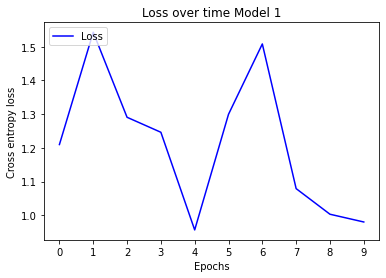

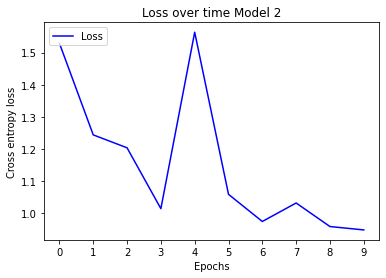

In [123]:
plt.plot(model0.loss_list, "-b", label="Loss")
plt.xticks(ticks=[i for i in range(len(model0.loss_list))])
plt.xlabel('Epochs')
plt.ylabel('Cross entropy loss')
plt.title('Loss over time Model 0')
plt.legend(loc="upper left")
plt.show()

plt.plot(model1.loss_list, "-b", label="Loss")
plt.xticks(ticks=[i for i in range(len(model1.loss_list))])
plt.xlabel('Epochs')
plt.ylabel('Cross entropy loss')
plt.title('Loss over time Model 1')
plt.legend(loc="upper left")
plt.show()

plt.plot(model2.loss_list, "-b", label="Loss")
plt.xticks(ticks=[i for i in range(len(model2.loss_list))])
plt.xlabel('Epochs')
plt.ylabel('Cross entropy loss')
plt.title('Loss over time Model 2')
plt.legend(loc="upper left")
plt.show()

## Experiment 2

In [36]:
model3 = MLP(layer_num = 2, batch_size = batch_size_global, activation = activation_leaky_ReLU, is_stochastic=True, add_bias=True, max_iters=iterations_global, learning_rate=.01, M=256, l1=0, l2=0, momentum=0, drop=0)
model4 = MLP(layer_num = 2, batch_size = batch_size_global, activation = activation_tanh, is_stochastic=True, add_bias=True, max_iters=iterations_global, learning_rate=.01, M=256, l1=0, l2=0, momentum=0, drop=0)

In [37]:
model3.fit(big_X_norm, big_labels_new)

In [38]:
model4.fit(big_X_norm, big_labels_new)

In [39]:
pred3 = model3.predict(test_norm)
pred4 = model4.predict(test_norm)

In [128]:
pred3c = getclasses(pred3)
pred4c = getclasses(pred4)

acc3 = evaluate_acc(pred3c, test_labels)
acc4 = evaluate_acc(pred4c, test_labels)

print("Test Accuracy of 2 layers with M=256, leak ReLU: ", acc3*100, "%")
print("Test Accuracy of 2 layers with M=256, tanh: ", acc4*100, "%")

Test Accuracy of 2 layers with M=256, leak ReLU:  53.89000000000001 %
Test Accuracy of 2 layers with M=256, tanh:  39.739999999999995 %


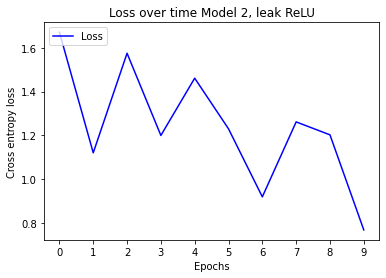

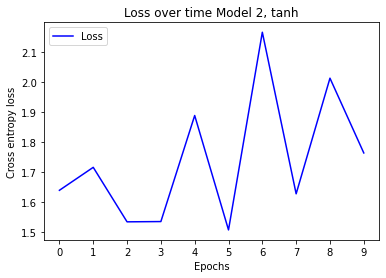

In [120]:
plt.plot(model3.loss_list, "-b", label="Loss")
plt.xticks(ticks=[i for i in range(len(model3.loss_list))])
plt.xlabel('Epochs')
plt.ylabel('Cross entropy loss')
plt.title('Loss over time Model 2, leak ReLU')
plt.legend(loc="upper left")
plt.show()

plt.plot(model4.loss_list, "-b", label="Loss")
plt.xticks(ticks=[i for i in range(len(model4.loss_list))])
plt.xlabel('Epochs')
plt.ylabel('Cross entropy loss')
plt.title('Loss over time Model 2, tanh')
plt.legend(loc="upper left")
plt.show()

## Experiment 3

In [42]:
model5 = MLP(layer_num = 2, batch_size = batch_size_global, activation = activation_ReLU, is_stochastic=True, add_bias=True, max_iters=iterations_global, learning_rate=.01, M=256, l1=0.01, l2=0, momentum=0, drop=0)
model6 = MLP(layer_num = 2, batch_size = batch_size_global, activation = activation_ReLU, is_stochastic=True, add_bias=True, max_iters=iterations_global, learning_rate=.01, M=256, l1=0, l2=0.01, momentum=0, drop=0)

In [43]:
model5.fit(big_X_norm, big_labels_new)

In [44]:
model6.fit(big_X_norm, big_labels_new)

In [45]:
pred5 = model5.predict(test_norm)
pred6 = model6.predict(test_norm)

In [129]:
pred5c = getclasses(pred5)
pred6c = getclasses(pred6)

acc5 = evaluate_acc(pred5c, test_labels)
acc6 = evaluate_acc(pred6c, test_labels)

print("Accuracy of 2 layers with M=256, ReLU, L1=0.01: ", acc5*100, "%")
print("Accuracy of 2 layers with M=256, ReLU, L2=0.01: ", acc6*100, "%")

Accuracy of 2 layers with M=256, ReLU, L1=0.01:  41.63 %
Accuracy of 2 layers with M=256, ReLU, L2=0.01:  50.14999999999999 %


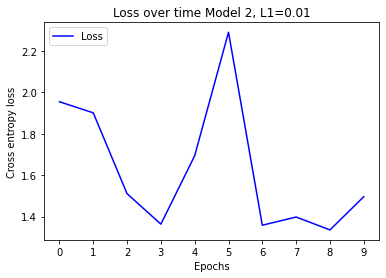

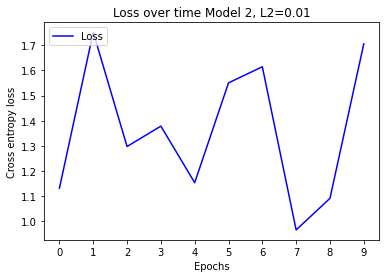

In [121]:
plt.plot(model5.loss_list, "-b", label="Loss")
plt.xticks(ticks=[i for i in range(len(model5.loss_list))])
plt.xlabel('Epochs')
plt.ylabel('Cross entropy loss')
plt.title('Loss over time Model 2, L1=0.01')
plt.legend(loc="upper left")
plt.show()

plt.plot(model6.loss_list, "-b", label="Loss")
plt.xticks(ticks=[i for i in range(len(model6.loss_list))])
plt.xlabel('Epochs')
plt.ylabel('Cross entropy loss')
plt.title('Loss over time Model 2, L2=0.01')
plt.legend(loc="upper left")
plt.show()

## Experiment 4

In [48]:
model7 = MLP(layer_num = 2, batch_size = batch_size_global, activation = activation_ReLU, is_stochastic=True, add_bias=True, max_iters=iterations_global, learning_rate=.01, M=256, l1=0, l2=0, momentum=0, drop=0)

In [49]:
model7.fit(big_X, big_labels_new)

In [131]:
pred7 = model7.predict(np_test)

In [132]:
pred7c = getclasses(pred7)

acc7 = evaluate_acc(pred7c, test_labels)

print("Accuracy of 2 layers with M=256, ReLU, data unnormalized: ", acc7*100, "%")

Accuracy of 2 layers with M=256, ReLU, data unnormalized:  10.0 %


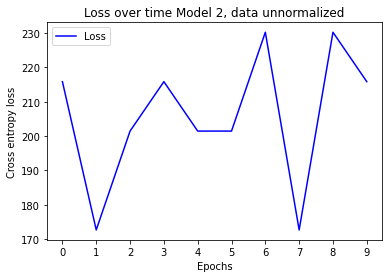

In [122]:
plt.plot(model7.loss_list, "-b", label="Loss")
plt.xticks(ticks=[i for i in range(len(model7.loss_list))])
plt.xlabel('Epochs')
plt.ylabel('Cross entropy loss')
plt.title('Loss over time Model 2, data unnormalized')
plt.legend(loc="upper left")
plt.show()

## Best MLP for comparison with CNNs.

In [105]:
model_best = MLP(layer_num = 2, batch_size = batch_size_global, activation = activation_ReLU, is_stochastic=True, add_bias=True, max_iters=iterations_global, learning_rate=.01, M=256, l1=0, l2=0, momentum=0, drop=0, acc=True, predic_test=test_norm, truth_test=test_labels, predic_train=big_X_norm, truth_train=big_labels)

In [106]:
model_best.fit(big_X_norm, big_labels_new)

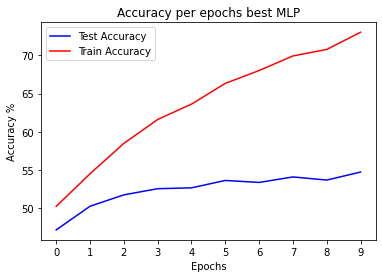

In [126]:
plt.plot(model_best.accuracy_list_test, "-b", label="Test Accuracy")
plt.plot(model_best.accuracy_list_train, "-r", label="Train Accuracy")
plt.xticks(ticks=[i for i in range(len(model_best.accuracy_list_test))])
plt.xticks(ticks=[i for i in range(len(model_best.accuracy_list_train))])
plt.xlabel('Epochs')
plt.ylabel('Accuracy %')
plt.title('Accuracy per epochs best MLP')
plt.legend(loc="upper left")
plt.show()

## NOTE: EXPERIMENT 5, 6 and 7 are in the other .ipynb file submitted. It contains the CNN implementation. Thank you.

## Extra experiments on MLP

### Width of MLP performance tests.

In [80]:
model32 = MLP(layer_num = 2, batch_size = batch_size_global, activation = activation_ReLU, is_stochastic=True, add_bias=True, max_iters=iterations_global, learning_rate=.01, M=32, l1=0, l2=0, momentum=0, drop=0)
model64 = MLP(layer_num = 2, batch_size = batch_size_global, activation = activation_ReLU, is_stochastic=True, add_bias=True, max_iters=iterations_global, learning_rate=.01, M=64, l1=0, l2=0, momentum=0, drop=0)
model128 = MLP(layer_num = 2, batch_size = batch_size_global, activation = activation_ReLU, is_stochastic=True, add_bias=True, max_iters=iterations_global, learning_rate=.01, M=128, l1=0, l2=0, momentum=0, drop=0)
model512 = MLP(layer_num = 2, batch_size = batch_size_global, activation = activation_ReLU, is_stochastic=True, add_bias=True, max_iters=iterations_global, learning_rate=.01, M=512, l1=0, l2=0, momentum=0, drop=0)
model1024 = MLP(layer_num = 2, batch_size = batch_size_global, activation = activation_ReLU, is_stochastic=True, add_bias=True, max_iters=iterations_global, learning_rate=.01, M=1024, l1=0, l2=0, momentum=0, drop=0)

In [82]:
model32.fit(big_X_norm, big_labels_new)
model64.fit(big_X_norm, big_labels_new)
model128.fit(big_X_norm, big_labels_new)
model512.fit(big_X_norm, big_labels_new)
model1024.fit(big_X_norm, big_labels_new)

In [83]:
pred32 = model32.predict(test_norm)
pred64 = model64.predict(test_norm)
pred128 = model128.predict(test_norm)
pred512 = model512.predict(test_norm)
pred1024 = model1024.predict(test_norm)

In [134]:
pred32c = getclasses(pred32)
pred64c= getclasses(pred64)
pred128c = getclasses(pred128)
pred512c = getclasses(pred512)
pred1024c = getclasses(pred1024)

acc32 = evaluate_acc(pred32c, test_labels)
acc64 = evaluate_acc(pred64c, test_labels)
acc128 = evaluate_acc(pred128c, test_labels)
acc512 = evaluate_acc(pred512c, test_labels)
acc1024 = evaluate_acc(pred1024c, test_labels)

print("Accuracy of 2 layers with M=32, ReLU:", acc32*100, "%")
print("Accuracy of 2 layers with M=64, ReLU:", acc64*100, "%")
print("Accuracy of 2 layers with M=128, ReLU:", acc128*100, "%")
print("Accuracy of 2 layers with M=256, ReLU:", acc2*100, "%")
print("Accuracy of 2 layers with M=512, ReLU:", acc512*100, "%")
print("Accuracy of 2 layers with M=1024, ReLU:", acc1024*100, "%")

Accuracy of 2 layers with M=32, ReLU: 48.620000000000005 %
Accuracy of 2 layers with M=64, ReLU: 50.62 %
Accuracy of 2 layers with M=128, ReLU: 52.790000000000006 %
Accuracy of 2 layers with M=256, ReLU: 53.14 %
Accuracy of 2 layers with M=512, ReLU: 53.949999999999996 %
Accuracy of 2 layers with M=1024, ReLU: 55.64 %


### Increasing training data performance test.

In [ ]:
# Test performance with increasing training data size.

In [114]:
k_10 = big_X_norm[0:10000]
k_20 = big_X_norm[0:20000]
k_30 = big_X_norm[0:30000]
k_40 = big_X_norm[0:40000]

k_10_labels = big_labels[0:10000]
k_20_labels = big_labels[0:20000]
k_30_labels = big_labels[0:30000]
k_40_labels = big_labels[0:40000]

k_10_l = label(k_10_labels, 10)
k_20_l = label(k_20_labels, 10)
k_30_l = label(k_30_labels, 10)
k_40_l = label(k_40_labels, 10)

In [115]:
model_10k = MLP(layer_num = 2, batch_size = batch_size_global, activation = activation_ReLU, is_stochastic=True, add_bias=True, max_iters=iterations_global, learning_rate=.01, M=256, l1=0, l2=0, momentum=0, drop=0)
model_20k = MLP(layer_num = 2, batch_size = batch_size_global, activation = activation_ReLU, is_stochastic=True, add_bias=True, max_iters=iterations_global, learning_rate=.01, M=256, l1=0, l2=0, momentum=0, drop=0)
model_30k = MLP(layer_num = 2, batch_size = batch_size_global, activation = activation_ReLU, is_stochastic=True, add_bias=True, max_iters=iterations_global, learning_rate=.01, M=256, l1=0, l2=0, momentum=0, drop=0)
model_40k = MLP(layer_num = 2, batch_size = batch_size_global, activation = activation_ReLU, is_stochastic=True, add_bias=True, max_iters=iterations_global, learning_rate=.01, M=256, l1=0, l2=0, momentum=0, drop=0)

In [116]:
model_10k.fit(k_10, k_10_l)
model_20k.fit(k_20, k_20_l)
model_30k.fit(k_30, k_30_l)
model_40k.fit(k_40, k_40_l)

In [117]:
pred_10k = model_10k.predict(test_norm)
pred_20k = model_20k.predict(test_norm)
pred_30k = model_30k.predict(test_norm)
pred_40k = model_40k.predict(test_norm)

In [133]:
pred10kc = getclasses(pred_10k)
pred20kc= getclasses(pred_20k)
pred30kc = getclasses(pred_30k)
pred40kc = getclasses(pred_40k)

acc10k = evaluate_acc(pred10kc, test_labels)
acc20k = evaluate_acc(pred20kc, test_labels)
acc30k = evaluate_acc(pred30kc, test_labels)
acc40k = evaluate_acc(pred40kc, test_labels)

print("Accuracy of 2 layers with M=256, ReLU, 10k training:", acc10k*100, "%")
print("Accuracy of 2 layers with M=256, ReLU, 20k training:", acc20k*100, "%")
print("Accuracy of 2 layers with M=256, ReLU, 30k training:", acc30k*100, "%")
print("Accuracy of 2 layers with M=256, ReLU, 40k training:", acc40k*100, "%")
print("Accuracy of 2 layers with M=256, ReLU, 40k training:", acc2*100, "%")

Accuracy of 2 layers with M=256, ReLU, 10k training: 45.53 %
Accuracy of 2 layers with M=256, ReLU, 20k training: 49.32 %
Accuracy of 2 layers with M=256, ReLU, 30k training: 51.17 %
Accuracy of 2 layers with M=256, ReLU, 40k training: 52.11 %
Accuracy of 2 layers with M=256, ReLU, 40k training: 53.14 %
